# 基于注意力的神经机器翻译

此笔记本训练一个将南非语翻译为英语的序列到序列（sequence to sequence，简写为 seq2seq）模型。此例子难度较高，需要对序列到序列模型的知识有一定了解。	

训练完此笔记本中的模型后，你将能够输入一个南非语句子，例如 *"Gaan binne."*，并返回其英语翻译 *"Come in."*

对于一个简单的例子来说，翻译质量令人满意。但是更有趣的可能是生成的注意力图：它显示在翻译过程中，输入句子的哪些部分受到了模型的注意。

<img src="https://tensorflow.google.cn/images/spanish-english.png" alt="spanish-english attention plot">

请注意：运行这个例子用一个 P100 GPU 需要花大约 10 分钟。

In [44]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

## 下载和准备数据集

我们将使用 http://www.manythings.org/anki/ 提供的一个语言数据集。这个数据集包含如下格式的语言翻译对：

```
Come in.	Gaan binne.
```

这个数据集中有很多种语言可供选择。我们将使用英语 - 南非语数据集。下载完数据集后，我们将采取下列步骤准备数据：

1. 给每个句子添加一个 *开始* 和一个 *结束* 标记（token）。
2. 删除特殊字符以清理句子。
3. 创建一个单词索引和一个反向单词索引（即一个从单词映射至 id 的词典和一个从 id 映射至单词的词典）。
4. 将每个句子填充（pad）到最大长度。

In [45]:
# 下载文件
'''
path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True)

path_to_file = os.path.dirname(path_to_zip)+"/spa-eng/spa.txt"
'''

path_to_file = "./lan/afr.txt"



In [46]:
# 将 unicode 文件转换为 ascii
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())

    # 在单词与跟在其后的标点符号之间插入一个空格
    # 例如： "he is a boy." => "he is a boy ."
    # 参考：https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    # 除了 (a-z, A-Z, ".", "?", "!", ",")，将所有字符替换为空格
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

    w = w.rstrip().strip()

    # 给句子加上开始和结束标记
    # 以便模型知道何时开始和结束预测
    w = '<start> ' + w + ' <end>'
    return w

In [47]:
en_sentence = u"Come in."
af_sentence = u"Gaan binne."
print(preprocess_sentence(en_sentence))
print(preprocess_sentence(af_sentence).encode('utf-8'))

<start> come in . <end>
b'<start> gaan binne . <end>'


In [48]:
# 1. 去除重音符号
# 2. 清理句子
# 3. 返回这样格式的单词对：[ENGLISH, SPANISH]
def create_dataset(path, num_examples):
    lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

    word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]

    return zip(*word_pairs)

In [49]:
en, af = create_dataset(path_to_file, None)
print(en[-1])
print(af[-1])

<start> i had an appointment at , but i got caught in traffic and couldn t get there in time . <end>
<start> ek het n afspraak gehad om , maar ek was vasgevang in die verkeer en kon nie daar kom in tyd nie . <end>


In [50]:
def max_length(tensor):
    return max(len(t) for t in tensor)

In [51]:
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

  return tensor, lang_tokenizer

In [52]:
def load_dataset(path, num_examples=None):
    # 创建清理过的输入输出对
    targ_lang, inp_lang = create_dataset(path, num_examples)

    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

### 限制数据集的大小以加快实验速度（可选）

在超过 10 万个句子的完整数据集上训练需要很长时间。为了更快地训练，我们可以将数据集的大小限制为 3 万个句子（当然，翻译质量也会随着数据的减少而降低）：

In [53]:
# 尝试实验不同大小的数据集
num_examples = 821
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

# 计算目标张量的最大长度 （max_length）
max_length_targ, max_length_inp = max_length(target_tensor), max_length(input_tensor)

In [54]:
# 采用 80 - 20 的比例切分训练集和验证集
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# 显示长度
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

656 656 165 165


In [55]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

In [56]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
511 ----> perskes
512 ----> proe
513 ----> soet
3 ----> .
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
547 ----> peaches
235 ----> taste
548 ----> sweet
3 ----> .
2 ----> <end>


### 创建一个 tf.data 数据集

In [57]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [58]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 25]), TensorShape([64, 23]))

## 编写编码器 （encoder） 和解码器 （decoder） 模型

实现一个基于注意力的编码器 - 解码器模型。关于这种模型，你可以阅读 TensorFlow 的 [神经机器翻译 (序列到序列) 教程](https://github.com/tensorflow/nmt)。本示例采用一组更新的 API。此笔记本实现了上述序列到序列教程中的 [注意力方程式](https://github.com/tensorflow/nmt#background-on-the-attention-mechanism)。下图显示了注意力机制为每个输入单词分配一个权重，然后解码器将这个权重用于预测句子中的下一个单词。下图和公式是 [Luong 的论文](https://arxiv.org/abs/1508.04025v5)中注意力机制的一个例子。

<img src="https://tensorflow.google.cn/images/seq2seq/attention_mechanism.jpg" width="500" alt="attention mechanism">

输入经过编码器模型，编码器模型为我们提供形状为 *(批大小，最大长度，隐藏层大小)* 的编码器输出和形状为 *(批大小，隐藏层大小)* 的编码器隐藏层状态。

下面是所实现的方程式：

<img src="https://tensorflow.google.cn/images/seq2seq/attention_equation_0.jpg" alt="attention equation 0" width="800">
<img src="https://tensorflow.google.cn/images/seq2seq/attention_equation_1.jpg" alt="attention equation 1" width="800">

本教程的编码器采用 [Bahdanau 注意力](https://arxiv.org/pdf/1409.0473.pdf)。在用简化形式编写之前，让我们先决定符号：

* FC = 完全连接（密集）层
* EO = 编码器输出
* H = 隐藏层状态
* X = 解码器输入

以及伪代码：

* `score = FC(tanh(FC(EO) + FC(H)))`
* `attention weights = softmax(score, axis = 1)`。 Softmax 默认被应用于最后一个轴，但是这里我们想将它应用于 *第一个轴*, 因为分数 （score） 的形状是 *(批大小，最大长度，隐藏层大小)*。最大长度 （`max_length`） 是我们的输入的长度。因为我们想为每个输入分配一个权重，所以 softmax 应该用在这个轴上。
* `context vector = sum(attention weights * EO, axis = 1)`。选择第一个轴的原因同上。
* `embedding output` = 解码器输入 X 通过一个嵌入层。
* `merged vector = concat(embedding output, context vector)`
* 此合并后的向量随后被传送到 GRU

每个步骤中所有向量的形状已在代码的注释中阐明：

In [59]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [60]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# 样本输入
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 25, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [61]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # 隐藏层的形状 == （批大小，隐藏层大小）
    # hidden_with_time_axis 的形状 == （批大小，1，隐藏层大小）
    # 这样做是为了执行加法以计算分数  
    hidden_with_time_axis = tf.expand_dims(query, 1)

    # 分数的形状 == （批大小，最大长度，1）
    # 我们在最后一个轴上得到 1， 因为我们把分数应用于 self.V
    # 在应用 self.V 之前，张量的形状是（批大小，最大长度，单位）
    score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(hidden_with_time_axis)))

    # 注意力权重 （attention_weights） 的形状 == （批大小，最大长度，1）
    attention_weights = tf.nn.softmax(score, axis=1)

    # 上下文向量 （context_vector） 求和之后的形状 == （批大小，隐藏层大小）
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [62]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 25, 1)


In [63]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # 用于注意力
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # 编码器输出 （enc_output） 的形状 == （批大小，最大长度，隐藏层大小）
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x 在通过嵌入层后的形状 == （批大小，1，嵌入维度）
    x = self.embedding(x)

    # x 在拼接 （concatenation） 后的形状 == （批大小，1，嵌入维度 + 隐藏层大小）
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # 将合并后的向量传送到 GRU
    output, state = self.gru(x)

    # 输出的形状 == （批大小 * 1，隐藏层大小）
    output = tf.reshape(output, (-1, output.shape[2]))

    # 输出的形状 == （批大小，vocab）
    x = self.fc(output)

    return x, state, attention_weights

In [64]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((64, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 1029)


## 定义优化器和损失函数

In [65]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## 检查点（基于对象保存）

In [66]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

## 训练

1. 将 *输入* 传送至 *编码器*，编码器返回 *编码器输出* 和 *编码器隐藏层状态*。
2. 将编码器输出、编码器隐藏层状态和解码器输入（即 *开始标记*）传送至解码器。
3. 解码器返回 *预测* 和 *解码器隐藏层状态*。
4. 解码器隐藏层状态被传送回模型，预测被用于计算损失。
5. 使用 *教师强制 （teacher forcing）* 决定解码器的下一个输入。
6. *教师强制* 是将 *目标词* 作为 *下一个输入* 传送至解码器的技术。
7. 最后一步是计算梯度，并将其应用于优化器和反向传播。

In [67]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # 教师强制 - 将目标词作为下一个输入
    for t in range(1, targ.shape[1]):
      # 将编码器输出 （enc_output） 传送至解码器
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # 使用教师强制
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [68]:
EPOCHS = 100

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
        print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                     batch,
                                                     batch_loss.numpy()))
  # 每 2 个周期（epoch），保存（检查点）一次模型
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 2.3606
Epoch 1 Loss 2.3877
Time taken for 1 epoch 37.384286642074585 sec

Epoch 2 Batch 0 Loss 2.1473
Epoch 2 Loss 1.9134
Time taken for 1 epoch 1.9655094146728516 sec

Epoch 3 Batch 0 Loss 1.6314
Epoch 3 Loss 1.7113
Time taken for 1 epoch 0.9971737861633301 sec

Epoch 4 Batch 0 Loss 1.5766
Epoch 4 Loss 1.6174
Time taken for 1 epoch 1.950385332107544 sec

Epoch 5 Batch 0 Loss 1.7114
Epoch 5 Loss 1.5549
Time taken for 1 epoch 0.993929386138916 sec

Epoch 6 Batch 0 Loss 1.4751
Epoch 6 Loss 1.4869
Time taken for 1 epoch 1.9381206035614014 sec

Epoch 7 Batch 0 Loss 1.5132
Epoch 7 Loss 1.4298
Time taken for 1 epoch 0.9956645965576172 sec

Epoch 8 Batch 0 Loss 1.3875
Epoch 8 Loss 1.3487
Time taken for 1 epoch 1.9514517784118652 sec

Epoch 9 Batch 0 Loss 1.2895
Epoch 9 Loss 1.2899
Time taken for 1 epoch 0.9939637184143066 sec

Epoch 10 Batch 0 Loss 1.2343
Epoch 10 Loss 1.2345
Time taken for 1 epoch 2.063859224319458 sec

Epoch 11 Batch 0 Loss 1.2453
Epoch 11 Loss 1.1782
T

Epoch 86 Loss 0.0082
Time taken for 1 epoch 2.0897557735443115 sec

Epoch 87 Batch 0 Loss 0.0061
Epoch 87 Loss 0.0082
Time taken for 1 epoch 1.0204713344573975 sec

Epoch 88 Batch 0 Loss 0.0065
Epoch 88 Loss 0.0077
Time taken for 1 epoch 2.2759838104248047 sec

Epoch 89 Batch 0 Loss 0.0054
Epoch 89 Loss 0.0072
Time taken for 1 epoch 1.0167045593261719 sec

Epoch 90 Batch 0 Loss 0.0053
Epoch 90 Loss 0.0071
Time taken for 1 epoch 2.0155069828033447 sec

Epoch 91 Batch 0 Loss 0.0058
Epoch 91 Loss 0.0062
Time taken for 1 epoch 1.0100529193878174 sec

Epoch 92 Batch 0 Loss 0.0053
Epoch 92 Loss 0.0069
Time taken for 1 epoch 2.0103113651275635 sec

Epoch 93 Batch 0 Loss 0.0083
Epoch 93 Loss 0.0072
Time taken for 1 epoch 1.0179274082183838 sec

Epoch 94 Batch 0 Loss 0.0091
Epoch 94 Loss 0.0075
Time taken for 1 epoch 2.122549533843994 sec

Epoch 95 Batch 0 Loss 0.0047
Epoch 95 Loss 0.0071
Time taken for 1 epoch 1.009688377380371 sec

Epoch 96 Batch 0 Loss 0.0090
Epoch 96 Loss 0.0072
Time taken 

## 翻译

* 评估函数类似于训练循环，不同之处在于在这里我们不使用 *教师强制*。每个时间步的解码器输入是其先前的预测、隐藏层状态和编码器输出。
* 当模型预测 *结束标记* 时停止预测。
* 存储 *每个时间步的注意力权重*。

请注意：对于一个输入，编码器输出仅计算一次。

In [69]:
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))

    sentence = preprocess_sentence(sentence)

    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                           maxlen=max_length_inp,
                                                           padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        # 存储注意力权重以便后面制图
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang.index_word[predicted_id] + ' '

        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

        # 预测的 ID 被输送回模型
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [70]:
# 注意力权重制图函数
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [71]:
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

## 恢复最新的检查点并验证

In [72]:
# 恢复检查点目录 （checkpoint_dir） 中最新的检查点
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> ek gaan slaap om tien . <end>
Predicted translation: i go to bed about ten . <end> 


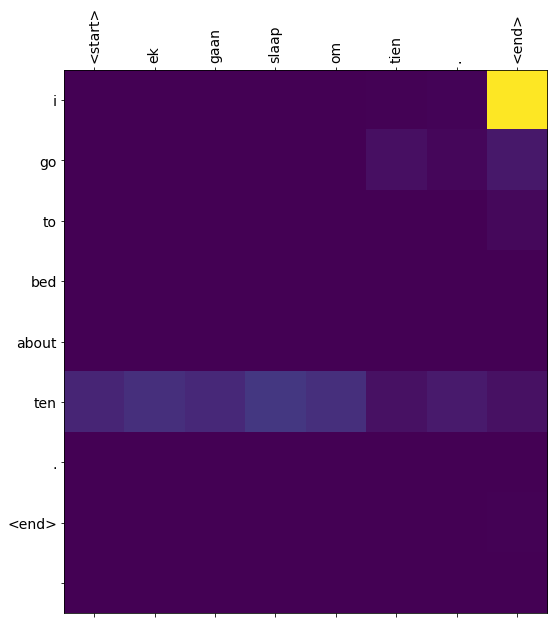

In [73]:
translate(u'Ek gaan slaap om tien.')

Input: <start> kan jy my hierso vat ? <end>
Predicted translation: can you take over here ? <end> 


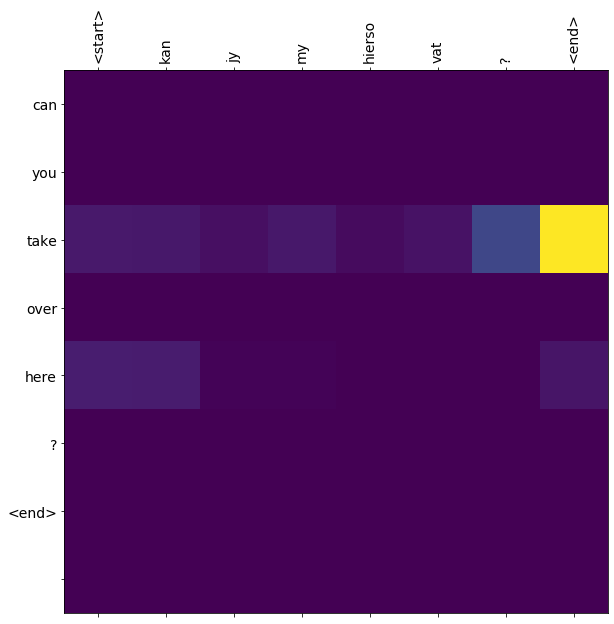

In [74]:
translate(u'Kan jy my hierso vat?')

Input: <start> is jy seker jy wil he dat ek jou moet help met jou huiswerk ? <end>
Predicted translation: if will you sure you don t want to ? <end> 


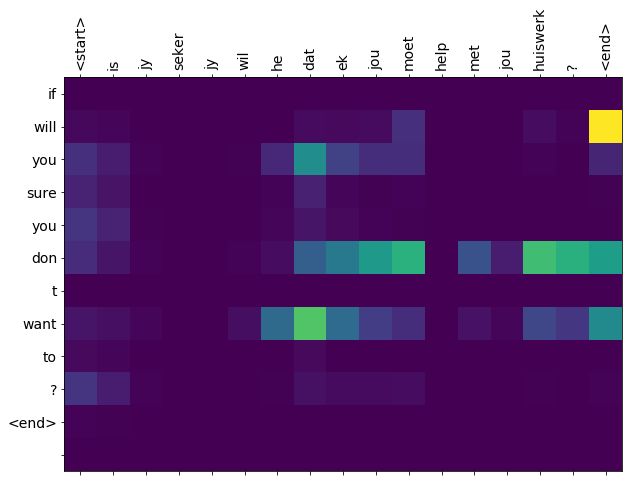

In [75]:
translate(u'Is jy seker jy wil hê dat ek jou moet help met jou huiswerk?')

Input: <start> ek soek werk . <end>
Predicted translation: i m looking for a job . <end> 


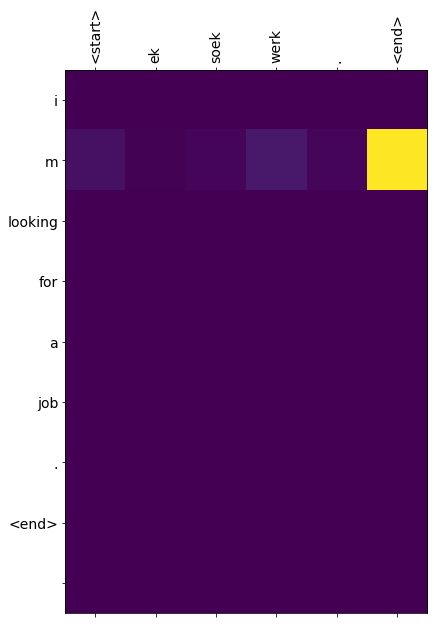

In [76]:
# 错误的翻译
translate(u'Ek soek werk.')